# Volume 3: Metropolis
    Kameron Lightheart
    MATH 405
    March 24, 2020

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from math import sqrt, exp, log
import seaborn as sbn

## Problem 1

Write a function that accepts an integer $n$ and returns a random spin configuration for an $n \times n$ lattice (as an $n \times n$ NumPy array of $1$s and $-1$s).
Test your function with $n = 100$, plotting the spin configuration via `plt.imshow()`.

In [2]:
def proposal(x,s):
    """The proposal function Q(x,y) = N(x|y,sI)."""
    return stats.multivariate_normal.rvs(mean=x, cov=s*np.eye(len(x)))

In [3]:
def propLogDensity(x):
    """Calculate the log of the proportional density."""
    logprob = muprior.logpdf(x[0]) + sig2prior.logpdf(x[1])
    logprob += stats.norm.logpdf(scores, loc=x[0], scale=sqrt(x[1])).sum()
    return logprob    # ^this is where the scores are used.

In [4]:
def acceptance(x, y):
    return min(0, propLogDensity(x) - propLogDensity(y))

In [5]:
def metropolis(x0, s, n_samples):
    """Use the Metropolis algorithm to sample from posterior.
    Parameters:
     x0 ((2,) ndarray): The first entry is mu, the second entry is sigma^2.
     s (float): The standard deviation parameter for the proposal function.
     n_samples (int): The number of samples to generate.
   
   Returns:
     draws ((n_samples, 2) ndarray): The MCMC samples.
     logprobs ((n_samples,) ndarray): The log density of the samples.
     accept_rate (float): The proportion of accepted proposed samples."""
    accept_counter = 0
    draws = np.empty((n_samples,2))
    logprob = np.empty(n_samples)
    x = x0.copy()
    for i in range(n_samples):
        xprime = proposal(x,s)
        a = np.random.uniform()
        if log(a) <= acceptance(xprime, x):
            accept_counter += 1
            x = xprime
        draws[i] = x
        logprob[i] = propLogDensity(x)
    return draws, logprob, accept_counter/n_samples

In [23]:
scores = np.load("examscores.npy")
alpha = 3
beta = 50
mu0 = 80
sig20 = 16

muprior = stats.norm(loc=mu0, scale=sqrt(sig20))
sig2prior = stats.invgamma(alpha, scale=beta)

draws, lprobs, rate = metropolis(np.array([40., 10.]), 20., 10000)
draws

array([[34.92453275, 15.98640689],
       [34.91905323, 22.74547219],
       [37.65581144, 22.22000452],
       ...,
       [83.87948453, 79.84720662],
       [83.87948453, 79.84720662],
       [87.81625148, 82.7049104 ]])

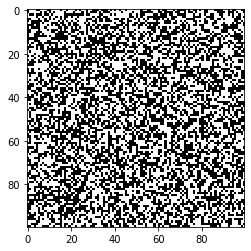

In [12]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    random_spin = np.zeros((n,n))
    for k in range(n):
        random_spin[k,:] = 2*np.random.binomial(1,.5, n) -1
    return random_spin
plt.imshow(random_lattice(100), cmap='gray')

## Problem 2

Write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Compute the energy $H(\sigma)$ of the spin configuration.
Be careful to not double count site pair interactions!

In [6]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    """
    # Computes the sum of all multiplication of entries by their neighbors
    # above, below and on both sides
    return -(np.sum(np.roll(L, 1, axis=0) * L) + np.sum(np.roll(L, 1, axis=1) * L))

## Problem 3

Write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair should have an equal probability $\frac{1}{n^2}$ of being chosen.

In [7]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1."""
    i, j = np.random.randint(n), np.random.randint(n)
    return i, j 

## Problem 4

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [8]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    """
    n = len(L)
    # Get energy from the specified location
    pair_energy = L[i,j] * L[(i+1) % (n-1),j] + \
                  L[i,j] * L[(i-1) % (n-1),j] + \
                  L[i,j] * L[i, (j+1) % (n-1)] + \
                  L[i,j] * L[i, (j-1) % (n-1)]
    
    # Compute flipped energy according to equation (1.2)
    return L_energy + 2 * pair_energy

## Problem 5

Write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculate whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

In [9]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration."""
    # Using equation (1.1) calc probability of acceptance
    if energy_new < energy_old:
        prob = 1
    else:
        prob = np.exp(beta * (energy_old - energy_new))
        
    # Return true or false based on that probability
    return np.random.binomial(1, prob)

## Problem 6

Write a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Use the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continue the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
Return the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Test your sampler on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough so that you will keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plot the proportional log probabilities, as well as a late sample from each test.


In [14]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    # Initialize a spin configuration using random_lattice
    L = random_lattice(n)
    weighted_energies = []
    
    for _ in range(burn_in):
        # use problem 3 to compute a random flip location
        i, j = flip_location(n)

        # Use update_energy() to compute H(𝜎∗)
        old_energy = lattice_energy(L)
        new_energy = updated_energy(L, old_energy, i, j)
        weighted_energies.append(-beta * new_energy)

        # accept or reject proposal
        accept_bool = accept(beta, old_energy, new_energy)
        
        if accept_bool:
            L[i,j] *= -1
    
    accepted = 0
    samples = []
        
    for _ in range(n_samples):
        # use problem 3 to compute a random flip location
        i, j = flip_location(n)

        # Use update_energy() to compute H(𝜎∗)
        old_energy = lattice_energy(L)
        new_energy = updated_energy(L, old_energy, i, j)
        weighted_energies.append(-beta * new_energy)

        # accept or reject proposal
        accept_bool = accept(beta, old_energy, new_energy)
        
        if accept_bool:
            accepted += 1
            L[i,j] *= -1
        samples.append(L)
    
    return samples, weighted_energies, accepted / n_samples

Acceptance Rate: 0.6806


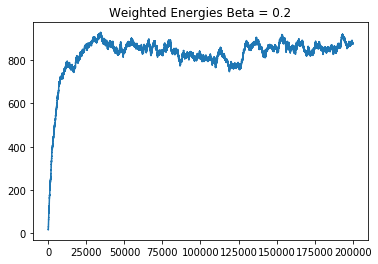

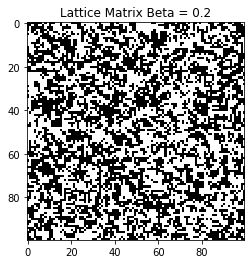

Acceptance Rate: 0.3346


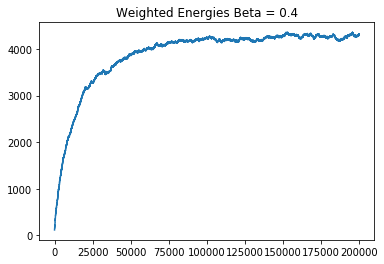

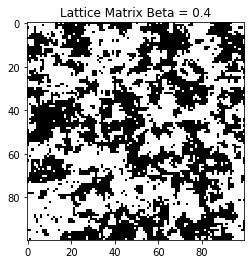

Acceptance Rate: 0.0532


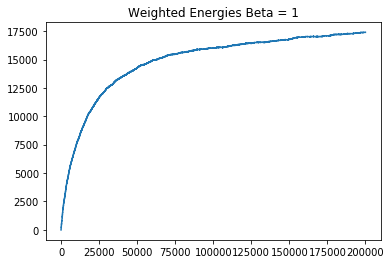

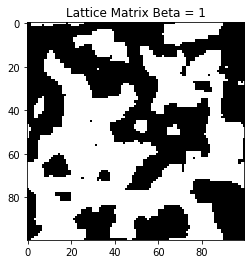

In [15]:
betas = [0.2, 0.4, 1]
for beta in betas:
    samples, energies, rate = ising_metropolis(beta)
    print("Acceptance Rate: {}".format(rate))
    plt.plot(energies)
    plt.title("Weighted Energies Beta = {}".format(beta))
    plt.show()
    plt.imshow(samples[-1], cmap='gray')
    plt.title("Lattice Matrix Beta = {}".format(beta))
    plt.show()